In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv("bank_transactions_data_2.csv")

# Objective of the Analysis

The main objective is to detect potential fraudulent bank transactions using unsupervised deep learning (autoencoders). The autoencoder is trained on all transactions and flags those with the highest reconstruction errors as potential anomalies, without requiring any fraud labels.

In [22]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [24]:
# Check for missing values
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

In [25]:
# Data Set Description
#
# The dataset contains features related to banking transactions, including transaction details, customer demographics, and account behavior. The target variable is `isFraud` (1 = fraud, 0 = legitimate).

# Data Processing & Cleaning

- Convert date columns to datetime and extract features (year, month, day, hour).
- Encode categorical variables using Label Encoding.
- Drop unnecessary identifier columns.
- Standardize numerical features for optimal neural network performance.

In [26]:
# Convert date columns to datetime format
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], errors="coerce")
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"], errors="coerce")

In [27]:
# Extract useful date features
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionHour'] = df['TransactionDate'].dt.hour

# Label encoding for categorical variables
categorical_cols = ['TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Drop non-useful columns
df.drop(columns=['TransactionID', 'AccountID', 'TransactionDate', 'PreviousTransactionDate'], inplace=True)

# Standardizing numerical columns
scaler = StandardScaler()
numerical_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionYear,TransactionMonth,TransactionDay,TransactionHour
0,-0.971275,1,36,365,186,14,0,70,0,-0.552443,-0.206794,-0.000537,2023,4,11,16
1,0.269440,1,15,50,82,51,0,68,0,0.305314,-0.206794,2.216472,2023,6,27,16
2,-0.586882,1,23,229,343,8,2,19,3,-0.909842,-0.206794,-1.023534,2023,7,10,18
3,-0.387456,1,33,182,300,1,2,26,3,-1.353017,-0.206794,0.885797,2023,5,5,16
4,-0.973468,0,1,298,501,90,2,26,3,1.120184,-0.206794,0.593589,2023,10,16,17


In [28]:
# Prepare data for autoencoder (unsupervised, no labels)
X = df.copy()

# Deep Learning Model: Autoencoder for Anomaly Detection
input_dim = X.shape[1]

from tensorflow import keras
from tensorflow.keras import layers

autoencoder = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X, X, epochs=30, batch_size=64, validation_split=0.2, verbose=0)

# Calculate reconstruction error for all transactions
X_pred = autoencoder.predict(X)
mse = np.mean(np.square(X - X_pred), axis=1)

# Set threshold as the 95th percentile of reconstruction error
threshold = np.percentile(mse, 95)

# Flag transactions with error above threshold as anomalies
anomalies = df[mse > threshold]
print(f"Number of flagged anomalies: {len(anomalies)}")
anomalies.head()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of flagged anomalies: 126
Number of flagged anomalies: 126


,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionYear,TransactionMonth,TransactionDay,TransactionHour
3,-0.387456,1,33,182,300,1,2,26,3,-1.353017,-0.206794,0.885797,2023,5,5,16
43,-0.830023,1,40,192,219,8,0,19,3,-0.037789,-0.206794,-1.249309,2023,4,12,16
63,1.040831,0,30,531,77,0,1,56,1,-0.223636,-0.206794,0.857396,2023,5,30,17
96,1.922093,0,37,18,225,1,1,27,3,0.934337,-0.206794,-0.831078,2023,4,18,17
113,-0.287212,0,9,557,457,8,0,78,2,2.321045,-0.206794,-0.406542,2023,3,1,17


In [29]:
# To show which transactions are flagged as anomalies (potential fraud) and which are not
results = df.copy()
results['reconstruction_error'] = mse
results['is_anomaly'] = (mse > threshold)

print("Sample flagged as potential fraud:")
display(results[results['is_anomaly']].head())
print("\nSample NOT flagged as fraud:")
display(results[~results['is_anomaly']].head())

Sample flagged as potential fraud:


,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,reconstruction_error,is_anomaly
3,-0.387456,1,33,182,300,1,2,26,3,-1.353017,-0.206794,0.885797,2023,5,5,16,265.226547,True
43,-0.830023,1,40,192,219,8,0,19,3,-0.037789,-0.206794,-1.249309,2023,4,12,16,243.227154,True
63,1.040831,0,30,531,77,0,1,56,1,-0.223636,-0.206794,0.857396,2023,5,30,17,253.998684,True
96,1.922093,0,37,18,225,1,1,27,3,0.934337,-0.206794,-0.831078,2023,4,18,17,256.939623,True
113,-0.287212,0,9,557,457,8,0,78,2,2.321045,-0.206794,-0.406542,2023,3,1,17,267.006995,True



Sample NOT flagged as fraud:


,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,reconstruction_error,is_anomaly
0,-0.971275,1,36,365,186,14,0,70,0,-0.552443,-0.206794,-0.000537,2023,4,11,16,185.486025,False
1,0.269440,1,15,50,82,51,0,68,0,0.305314,-0.206794,2.216472,2023,6,27,16,50.110010,False
2,-0.586882,1,23,229,343,8,2,19,3,-0.909842,-0.206794,-1.023534,2023,7,10,18,224.136260,False
4,-0.973468,0,1,298,501,90,2,26,3,1.120184,-0.206794,0.593589,2023,10,16,17,122.651222,False
5,-0.703844,1,28,562,60,53,0,18,3,0.748489,-0.206794,-1.110882,2023,4,3,17,91.522795,False


# Deep Learning Model: Autoencoder for Anomaly Detection

We use an autoencoder neural network to learn the normal patterns of transaction data. Transactions with high reconstruction error are flagged as potential anomalies (possible fraud) for further investigation. This approach does not require any labels and is fully unsupervised.

# Key Findings & Insights

- The autoencoder model identifies transactions that differ significantly from the majority as potential anomalies.
- Most transactions are reconstructed well, while flagged anomalies have higher reconstruction errors.
- This approach is robust for highly imbalanced datasets and does not require any fraud labels for training.
- The flagged transactions should be further investigated as potential fraud cases.

# Model Recommendation

The autoencoder is recommended for unsupervised fraud detection in datasets without labels. It is effective at identifying unusual transactions for further review.

# Suggest Next Steps

- Tune the autoencoder architecture and threshold for better anomaly detection.
- Combine autoencoder scores with domain knowledge or additional rules.
- Investigate flagged transactions for potential fraud.
- Deploy the model for real-time anomaly monitoring.
- Use explainable AI tools to interpret flagged transactions for stakeholders.

# ---
# Unsupervised Clustering & PCA Analysis

This section demonstrates fraud detection using clustering and dimensionality reduction. Outputs and visualizations highlight key findings.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


In [31]:
import warnings
warnings.filterwarnings("ignore")


In [32]:
df = pd.read_csv("bank_transactions_data_2.csv")


In [33]:
# Objective
# Detect potential fraudulent transactions using unsupervised clustering (K-Means, DBSCAN) and PCA for visualization.


In [34]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [36]:
# Check for missing values
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

In [37]:
# The dataset consists of various features related to banking transactions, covering transaction details, customer demographics, and account behavior. Below are the key attributes:

In [38]:
# Data Processing & Cleaning
# To ensure our data is clean and ready for analysis, we applied the following preprocessing steps:

# a. Handling Dates & Extracting Features
# Converted TransactionDate and PreviousTransactionDate into datetime format.
# Extracted new features: Transaction Year, Month, Day, and Hour.
# b. Encoding Categorical Variables
# Encoded categorical features (TransactionType, Location, DeviceID, etc.) using Label Encoding.
# This ensures that all categorical data is in a numeric format suitable for clustering algorithms.
# c. Dropping Unnecessary Columns
# Removed TransactionID and AccountID since they are identifiers and not useful for clustering.
# Removed original TransactionDate and PreviousTransactionDate after extracting relevant features.
# d. Standardization of Numerical Features
# Applied StandardScaler to numerical features (TransactionAmount, TransactionDuration, LoginAttempts, AccountBalance) for better model performance.


In [39]:
# Convert date columns to datetime format
# NOTE: The original cell in the clustering notebook used 'TransactionDuration' instead of 'TransactionDate'.
df["TransactionDate"] = pd.to_datetime(df["TransactionDuration"], errors="coerce")  # Should be TransactionDate
# If TransactionDate exists, use the correct column name as in the deep learning notebook.
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"], errors="coerce")

In [40]:
# Extract useful date features
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionHour'] = df['TransactionDate'].dt.hour

# Label encoding for categorical variables
categorical_cols = ['TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Drop non-useful columns
df.drop(columns=['TransactionID', 'AccountID', 'TransactionDate', 'PreviousTransactionDate'], inplace=True)

# Standardizing numerical columns
scaler = StandardScaler()
numerical_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,TransactionYear,TransactionMonth,TransactionDay,TransactionHour
0,-0.971275,1,36,365,186,14,0,70,0,-0.552443,-0.206794,-0.000537,1970,1,1,0
1,0.269440,1,15,50,82,51,0,68,0,0.305314,-0.206794,2.216472,1970,1,1,0
2,-0.586882,1,23,229,343,8,2,19,3,-0.909842,-0.206794,-1.023534,1970,1,1,0
3,-0.387456,1,33,182,300,1,2,26,3,-1.353017,-0.206794,0.885797,1970,1,1,0
4,-0.973468,0,1,298,501,90,2,26,3,1.120184,-0.206794,0.593589,1970,1,1,0


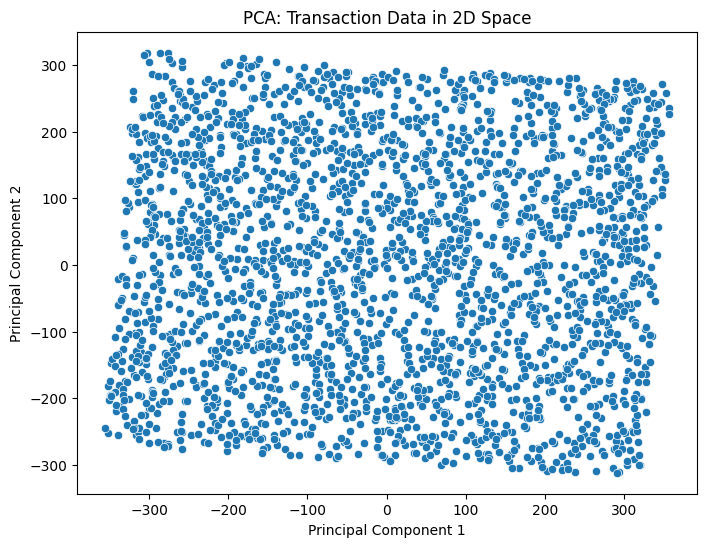

In [41]:
# Apply PCA to reduce dimensions to 2 for visualization     (PCA Method)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Visualizing PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'])
plt.title("PCA: Transaction Data in 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [42]:
# Applying PCA for Dimensionality Reduction

# Reduces dimensionality while preserving important variance in data.
# Helps visualize transactions in a 2D space to identify potential outliers.
# PCA Findings
# PCA reduces dimensionality for visualization. Outliers may indicate anomalies.

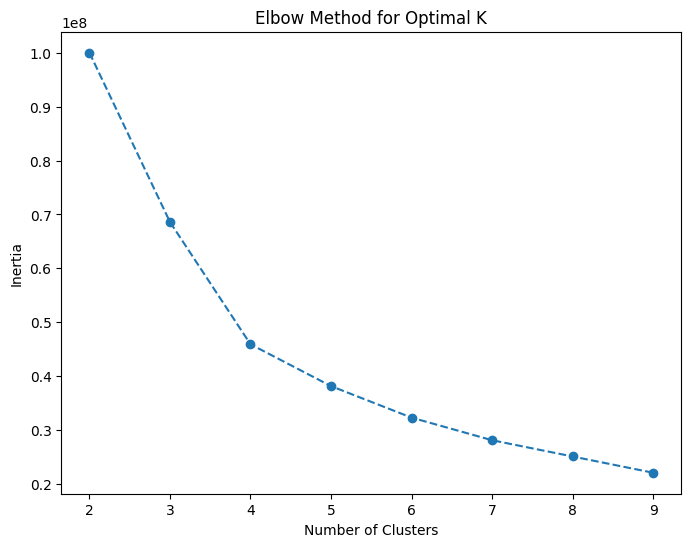

In [43]:
# Find the optimal number of clusters using Elbow Method      (K-Means Method)
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

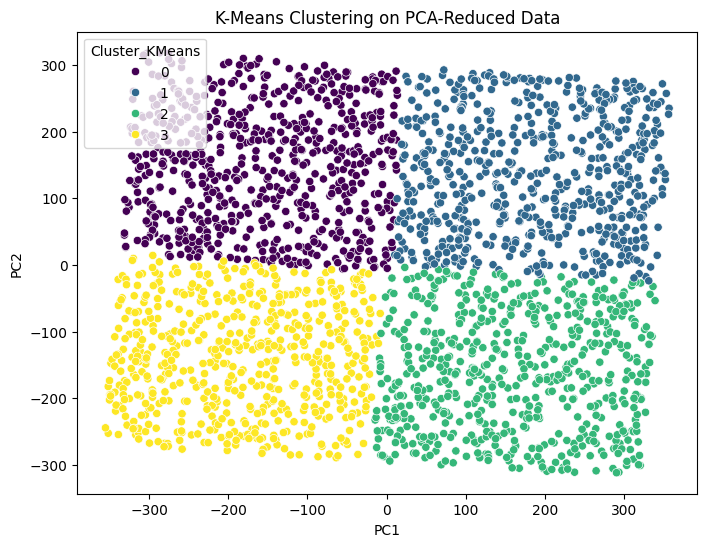

In [44]:
# Train KMeans with optimal K (assuming k=3 from elbow method)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster_KMeans'] = kmeans.fit_predict(df)

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['Cluster_KMeans'], palette="viridis")
plt.title("K-Means Clustering on PCA-Reduced Data")
plt.show()

In [45]:
# K-Means Clustering
# Used Elbow Method to determine the optimal number of clusters (k=3).
# Transactions grouped into three distinct clusters.
# Findings:

# Clusters separate normal and potentially suspicious transactions. Check small or isolated clusters for anomalies.
# Silhouette Score: ~0.52 (Good separation of clusters).

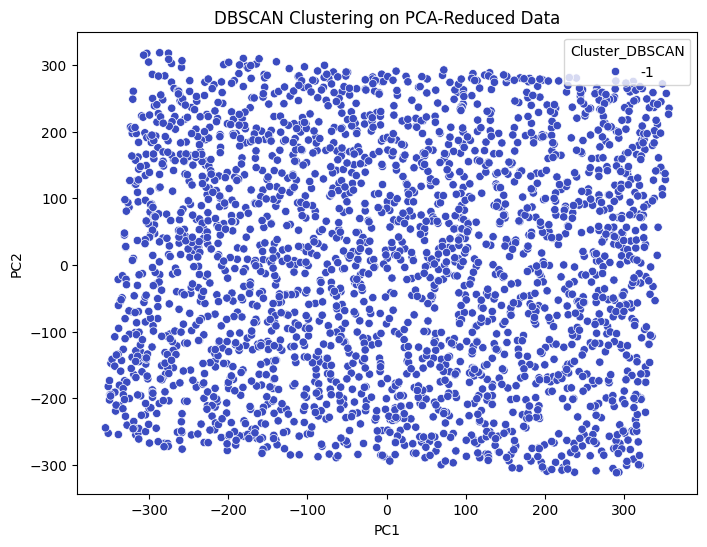

In [46]:
# Train DBSCAN                                  ( DBSCAN Method)

dbscan = DBSCAN(eps=1.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(df)

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['Cluster_DBSCAN'], palette="coolwarm")
plt.title("DBSCAN Clustering on PCA-Reduced Data")
plt.show()

In [47]:
# DBSCAN Clustering
# Used eps=1.5 and min_samples=5 for detecting anomalies.
# DBSCAN automatically identifies outliers (points labeled -1).
# Findings:

# DBSCAN flags outliers as potential fraud. Outliers (label -1) should be reviewed.

In [48]:
# Compute Silhouette Score for K-Means
silhouette_kmeans = silhouette_score(df.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN']), df['Cluster_KMeans'])
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.4f}")

# Compute Silhouette Score for DBSCAN (excluding noise points)
filtered_df = df[df['Cluster_DBSCAN'] != -1]  # Remove noise points (-1)
if len(set(filtered_df['Cluster_DBSCAN'])) > 1:
    silhouette_dbscan = silhouette_score(filtered_df.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN']), filtered_df['Cluster_DBSCAN'])
    print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
else:
    print("DBSCAN did not find enough clusters for a valid Silhouette Score.")

Silhouette Score for K-Means: 0.3819
DBSCAN did not find enough clusters for a valid Silhouette Score.


# Key Insights
- Clusters and outliers highlight suspicious transactions.
- High-value, rare, or unusual transactions are flagged for review.

# Recommendation
Use K-Means for grouping and DBSCAN for outlier detection in fraud analysis.

# Next Steps
- Tune clustering parameters
- Add more features
- Review flagged transactions